# Coursework 3: RNNs

#### Instructions

Please submit on CATe a zip file named *CW3_RNNs.zip* containing a version of this notebook with your answers. Write your answers in the cells below for each question.


## Recurrent models coursework

This coursework is separated into a coding and a theory component.

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the RNN tutorial: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

### Part 1 - Coding
In this part you will have to:

- Implement an LSTM
- Implement a GRU

### Part 2 - Theory

Here you will answer some theoretical questions about RNNs -- no detailed proofs and no programming.

### Part 1: Coding

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
dataset_folder = './' # this should change depending on where you have stored the data files

In [ ]:
!wget http://www.doc.ic.ac.uk/~pam213/co460_files/data_speech_commands_v0.02.zip
! mkdir ./data_speech_commands_v0.02
!unzip data_speech_commands_v0.02.zip -d ./data_speech_commands_v0.02/

--2021-03-07 14:58:16--  http://www.doc.ic.ac.uk/~pam213/co460_files/data_speech_commands_v0.02.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245500277 (234M) [application/zip]
Saving to: ‘data_speech_commands_v0.02.zip.3’

data_speech_command 100%[===================>] 234.13M  1.30MB/s    in 2m 25s  

2021-03-07 15:00:42 (1.61 MB/s) - ‘data_speech_commands_v0.02.zip.3’ saved [245500277/245500277]

mkdir: cannot create directory ‘./data_speech_commands_v0.02’: File exists
Archive:  data_speech_commands_v0.02.zip
replace ./data_speech_commands_v0.02/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Initial code before coursework questions start:

In [ ]:
import math
import os
import random
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


In [ ]:
def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

In [ ]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())
        
        # C - new list is created for each new key
        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "data_speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "data_speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)

        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        # C - new set is created for each new key
        class_to_filename = defaultdict(set)
        with open(self.root_dir + "data_speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "data_speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

In [ ]:

train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

batch_size = 100


num_epochs = 5
valid_every_n_steps = 20
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

### Question 1:  Finalise the LSTM and GRU cells by completing the missing code

You are allowed to use nn.Linear.

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        ########################################################################
        ## START OF YOUR CODE - Question 1a) Complete the missing code
        ########################################################################

        # LSTM cells have 4 neural network layers
        # the weights learned by the linear layers before passing to the 
        # non linear activations are different. Do one pass of 4 times the size,
        # and split it later
        self.x2h = nn.Linear(self.input_size, 4*self.hidden_size, bias = self.bias)
        self.h2h = nn.Linear(self.hidden_size, 4*self.hidden_size, bias = self.bias)
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)
            
        # We used hx to pack both the hidden and cell states
        hx, cx = hx
        
        ########################################################################
        ## START OF YOUR CODE - Question 1b) Complete the missing code
        ########################################################################
        # concatenate input and hidden state (coming from previous cell)
        # to use on each of the 4 cell's network's layers
        gates_input = self.x2h.forward(input) + self.h2h.forward(hx)
        gates_input = gates_input.squeeze()
        # split to get the input for each of the 4 gates
        forget_gate, input_gate, candidate_gate, output_gate = gates_input.chunk(4,1)
        
        # Activations
        forget_gate = torch.sigmoid(forget_gate)
        input_gate = torch.sigmoid(input_gate)
        candidate_gate = torch.tanh(candidate_gate)
        output_gate = torch.sigmoid(output_gate)

        # Pointwise multiplication operations
        cy = forget_gate*cx + input_gate*candidate_gate
        hy = output_gate * torch.tanh(cy)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return (hy, cy)

class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        activation = getattr(nn.functional, self.nonlinearity)
        hy = activation(self.x2h(input) + self.h2h(hx))

        return hy

    
    
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE - Question 1c) Complete the missing code
        ########################################################################
        self.x2h = nn.Linear(self.input_size, 3*self.hidden_size, bias - self.bias)
        self.h2h = nn.Linear(self.hidden_size, 3*self.hidden_size, bias = self.bias)

        # don't use this, as it makes the forward pass more confusing. Follow
        # same method as for LSTM (where we had 4 network layers instead of 3)
        #self.x2r = nn.Linear(self.input_size, self.hidden_size, bias = self.bias)
        #self.h2r = nn.Linear(self.hidden_size, self.hidden_size, bias = self.bias)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE - Question 1d) Complete the missing code
        ########################################################################
        # added this when the dimensions of the matrices weren't matching
        input = input.view(-1, input.size(1))
        gates_x = self.x2h.forward(input)
        gates_x = gates_x.squeeze()
        gates_h = self.h2h.forward(hx)
        gates_h = gates_h.squeeze()

        # notation from slides
        x_z, x_r, x_h = gates_x.chunk(3,1)
        h_z, h_r, h_h = gates_h.chunk(3,1)

        # activations (notation from slide in the notes)
        z = torch.sigmoid(x_z + h_z)
        r = torch.sigmoid(x_r + h_r)
        h = torch.tanh(r*h_h + x_h)

        hy = (1-z) * hx + z *h

        '''
        #this was my attempt to divide in x2h and x2r ... 
        # concatenate input and hidden state (coming from previous cell)
        # to use on each of the 2 hidden cell gatws
        hidden_gates_input = self.x2h.forward(input) + self.h2h.forward(hx)
        hidden_gates_input = hidden_gates_input.squeeze()

        # split into 2 for the two different gates
        update_gate, current_memory = hidden_gates_input.chunk(2,1)

        # concatenate input and hidden state for recurrent gate
        recurrent_gate = self.x2r.forward(input) + self.h2r.forward(hx)
        recurrent_gate = recurrent_gate_input.squeeze()

        #activations
        update_gate = torch.sigmoid(update_gate)
        recurrent_gate = torch.sigmoid(recurrent_gate)
        # do i need a linear activation below before the tanh
        current_memory = torch.tanh(recurrent_gate*current_memory)

        hy = (1 - update_gate)*h_x + update_gate * current_memory
        '''
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return hy

### Question 2:  Finalise the RNNModel and BidirRecurrentModel

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE - Question 2a) Complete the missing code
        #
        #  Append the appropriate LSTM cells to rnn_cell_list
        ########################################################################
          self.rnn_cell_list.append(LSTMCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias))
          for l in range(1, self.num_layers):
            self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias))
          
              
        ########################################################################
        ## END OF YOUR CODE
        ######################################################################## 

        elif mode == 'GRU':
            
        ########################################################################
        ## START OF YOUR CODE - Question 2b) Complete the missing code
        #
        #  Append the appropriate GRU cells to rnn_cell_list
        ########################################################################
          self.rnn_cell_list.append(GRUCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias))
          for l in range(1, self.num_layers):
            self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################        
        
        elif mode == 'RNN_TANH':
            
                    
        ########################################################################
        ## START OF YOUR CODE - Question 2c) Complete the missing code
        #
        #  Append the appropriate RNN cells to rnn_cell_list
        ########################################################################
          self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
          for l in range(1, self.num_layers):
            self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


                
        elif mode == 'RNN_RELU':
            
        ########################################################################
        ## START OF YOUR CODE - Question 2d) Complete the missing code
        #
        #  Append the appropriate RNN cells to rnn_cell_list
        ########################################################################
          self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
          for l in range(1, self.num_layers):
            self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):

        outs = []
        h0 = [None] * self.num_layers if hx is None else list(hx)
        # In this forward pass we want to create our RNN from the rnn cells,
        # ..taking the hidden states from the final RNN layer and passing these 
        # ..through our fully connected layer (fc).
        
        # The multi-layered RNN should be able to run when the mode is either 
        # .. LSTM, GRU, RNN_TANH or RNN_RELU.
        
        ########################################################################
        ## START OF YOUR CODE - Question 2e) Complete the missing code
        #
        #  HINT: You may need a special case for LSTMs
        ########################################################################
        X = list(input.permute(1, 0, 2))
        
        for j, l in enumerate(self.rnn_cell_list):
          hx_minus_one = h0[j]
          for i in range(input.shape[1]):
            hx = l(X[i], hx_minus_one)
            hx_minus_one = hx
            if self.mode == 'LSTM':
              #account fot the fact that LSTM also has cell states
              X[i] = hx[0]
            else: 
              X[i] = hx

        outs = X
    
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        out = outs[-1].squeeze()

        out = self.fc(out)
        
        
        return out
    

class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        self.rnn_cell_list_rev = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE - Question 2f) Complete the missing code
        #
        #  Create code for the following 'mode' values:
        # 'LSTM', 'GRU', 'RNN_TANH' and 'RNN_RELU'
        ########################################################################
         ##add everything to the other list as well!!!!
         
        if mode == 'LSTM':
          self.rnn_cell_list.append(LSTMCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias))
          self.rnn_cell_list_rev.append(LSTMCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias))
          for l in range(1, self.num_layers):
            self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias)) 
            self.rnn_cell_list_rev.append(LSTMCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias))

        elif mode == 'GRU':
          self.rnn_cell_list.append(GRUCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias))
          self.rnn_cell_list_rev.append(GRUCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias))
          for l in range(1, self.num_layers):
            self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias)) 
            self.rnn_cell_list_rev.append(GRUCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias))        
               
        
        elif mode == 'RNN_TANH':
          self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
          self.rnn_cell_list_rev.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
          for l in range(1, self.num_layers):
            self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            self.rnn_cell_list_rev.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))

                
        elif mode == 'RNN_RELU':
          self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
          self.rnn_cell_list_rev.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
          for l in range(1, self.num_layers):
            self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            self.rnn_cell_list_rev.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))



        else:
            raise ValueError("Invalid RNN mode selected.")


        #self.att_fc = nn.Linear(self.hidden_size*2, 1)
        self.fc = nn.Linear(self.hidden_size *2, self.output_size)

    def forward(self, input, hx=None):
        
        # In this forward pass we want to create our Bidirectional RNN from the rnn cells,
        # .. taking the hidden states from the final RNN layer with their reversed counterparts
        # .. before concatening these and running them through the fully connected layer (fc)
        
        # The multi-layered RNN should be able to run when the mode is either 
        # .. LSTM, GRU, RNN_TANH or RNN_RELU.
        
        ########################################################################
        ## START OF YOUR CODE  - Question 2g) Complete the missing code
        ########################################################################
        outs = []
        outs_rev = []

        h0 = [None] * self.num_layers if hx is None else list(hx)
        #reverse the list                                                     
        r_h0 = [None] * self.num_layers if hx is None else list(hx)[::-1]
        X = list(input.permute(1, 0, 2))
        X_rev = X[::-1]

        for j, l in enumerate(self.rnn_cell_list):
          hx_minus_one = h0[j]
          hx_minus_one_rev = r_h0[j]
          for i in range(input.shape[1]):
            hx = l(X[i], hx_minus_one)
            hx_minus_one = hx
            if self.mode == 'LSTM':
              X[i] = hx[0]
            else: 
              X[i] = hx
            
            #reverse pass
            l = self.rnn_cell_list_rev[j]
            hx_rev = l(X_rev[i], hx_minus_one_rev)
            hx_minus_one_rev = hx_rev
            if self.mode == 'LSTM':
              X_rev[i] = hx_rev[0]
            else: 
              X_rev[i] = hx_rev

        outs = X
        outs_rev = X_rev

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze()
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)
        out = self.fc(out)
        return out

The code below trains a network based on your code above. This should work without error:

In [ ]:

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

hidden_dim = 32
layer_dim = 1
bias = True

### Change the code below to try running different models:
#model = RNNModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim)
#model = RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)
#model = RNNModel("RNN_TANH", input_dim, hidden_dim, layer_dim, bias, output_dim) # check this one, training is bad
#model = RNNModel("RNN_RELU", input_dim, hidden_dim, layer_dim, bias, output_dim)
model = BidirRecurrentModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim)
#model = BidirRecurrentModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)
#model = BidirRecurrentModel("RNN_TANH", input_dim, hidden_dim, layer_dim, bias, output_dim)
#model = BidirRecurrentModel("RNN_RELU", input_dim, hidden_dim, layer_dim, bias, output_dim)



if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct // total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct // total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



Iteration: 20. Loss: 1.0410250425338745. V-Accuracy: 57  T-Accuracy: 55
Iteration: 40. Loss: 0.9900978803634644. V-Accuracy: 55  T-Accuracy: 55
Iteration: 60. Loss: 0.9633840322494507. V-Accuracy: 57  T-Accuracy: 55
Iteration: 80. Loss: 0.9217507839202881. V-Accuracy: 65  T-Accuracy: 63
Iteration: 100. Loss: 0.8641367554664612. V-Accuracy: 63  T-Accuracy: 63
Iteration: 120. Loss: 0.7949838042259216. V-Accuracy: 67  T-Accuracy: 66
Iteration: 140. Loss: 0.7554091811180115. V-Accuracy: 66  T-Accuracy: 66
Iteration: 160. Loss: 0.6998918652534485. V-Accuracy: 68  T-Accuracy: 66
Iteration: 180. Loss: 0.763008177280426. V-Accuracy: 69  T-Accuracy: 68
Iteration: 200. Loss: 0.642475962638855. V-Accuracy: 72  T-Accuracy: 69
Iteration: 220. Loss: 0.6653320789337158. V-Accuracy: 75  T-Accuracy: 73
Iteration: 240. Loss: 0.6442980766296387. V-Accuracy: 73  T-Accuracy: 73
Iteration: 260. Loss: 0.5537006258964539. V-Accuracy: 74  T-Accuracy: 73
Iteration: 280. Loss: 0.6782414317131042. V-Accuracy: 68 

## Part 2: Theoretical questions

#### Theory question 1: 
What is the _vanishing gradients problem_ and why does it occur? Which activation functions are more or less impacted by this, and why?

#### Your answers:
* Your answer here describing vanishing gradients problem

When training RNNs, the gradients need to be backpropagated through the layers and through time. The vanishing gradient problem is described at a point in the training when the gradient of the loss with respect to the weights decreases to 0. This causes the weights to stop updating and consequently the network stops learning and stabilises in a sub-optimal solution.

From a more mathematical perspective, the vanishing gradient problem occurs when we perform  many continued multiplications of matrices with values close to 0. The equation of the gradient of the loss with respect to W_h is described below (with the part that causes the issues highlighted in red). Vanishing gradient occurs when the ratio of each hidden state with the previous one is smaller than 1. This can also be thought of in terms of the eigen value decomposition of the jacobian matrices. If the previous hidden state has a larger eigenvalue than the current hidden state, it will "dominate" the ratio, and cause the gradient to vanish (the converse situation is the exploding gradient probelm).The deeper the network, the more problematic the vanishing problem can become.

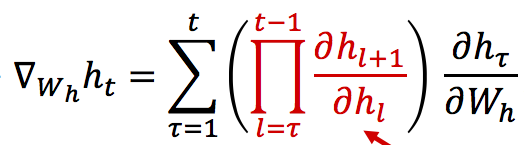

* Two examples of activation functions more impacted by vanishing gradients

The activation functions that are usually more affected by the vanishing gradient problem are the ones that have a derivative that is always smaller than 1, for example tanh and sigmoid
* Two examples of activation functions less impacted by vanishing gradients, why are they impacted less?

Conversely, the functions less affected by the vanishing gradient problem are the ones whose derivative is not always smaller than 1, like ReLU and all its variants like leaky ReLU, parametric ReLU or Exponential Linear Unit (ELU)



#### Theory question 2: 
Why do LSTMs help address the vanishing gradient problem compared to a vanilla RNN?

LSTMs introduce a cell state and a gated mechanism that control cell state updates and output values. The gates control what information in the cell state is forgotten (forget gate), which inputs will be updated (input gate)  with which values (candidate cell update - which keeps long term dependencies), and what information in the cell state is going to pass through the network (output gate). 

The error gradient is the sum of the different errors through time. In the LSTM case, for the gradient to vanish, all the subgradients have to vanish. It is unlikely that all of the error gradients vanish, since the network has the forget gate that helps control the different gradients values at the different times (by always controlling what information should not be forgotten). In a way, the gates give the network the power to decide how much the gradients "vanish" through time.

#### Theory question 3: 

The plot below shows the training curves for three models A, B, and C, trained on the same dataset up to 100 epochs. The three models are a RNN, a LSTM and a GRU, not necessarily in that order.

* Which could plausibly be which? Why? Please explain your reasoning.

(In the cell below please set the values for A_model, B_model and C_model to be 'RNN', 'LSTM' or 'GRU'. This needs to be exact for the automatic marking.)

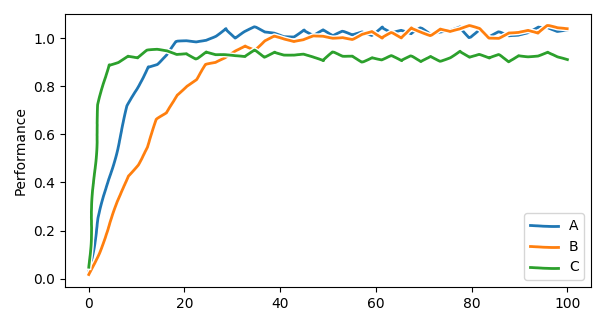

In [ ]:
from IPython.display import Image, display
display(Image(filename='Performance by epoch.png', width=550))

In [ ]:
# Answers below:

A_model = 'GRU'
B_model = 'LSTM'
C_model = 'RNN'

# Give your reasons below:

# see answer in the text cell below!


There are two things that can be explored in the graph above to decide which graph corresponds to each model. One is overall performance, and the other one is time to convergence. 

By looking at the overall performance, it is clear that model C has worse performance, while A and B have similar performance. This suggests that model C is the vanilla RNN. The other two models correspond to GRU and LSTM. It is reasonable that GRU and LSTM have similar overall performance, since for many task, the greater number of parameters in LSTM doesn't translate into better performance (when LSTM might result in better performance and viceversa is further explained in question 4)

By looking at the time to convergence, you can see that model C converges the fastest, reinforcing the idea that C is the vanilla RNN. When comparing between model A and B, model A converges quicker. This hints that model A is the GRU and B is the LSTM. GRU is a simpler model with fewer parameters than LSTM, which is why it coverges faster.



#### Theory question 4: 

When might you choose to use each of the three different types of models?

#### Your answers:
* Type of problem when best to use vanilla RNN:

Vanilla RNN is a simpler model than GRU and LSTM. Since it has fewer parameters it is less computationally expensive to train. For simpler tasks, when a very deep model is not needed (therefore the vanishing gradient problem might not be as problematic) using a vanilla RNN could be a better option.
* Type of problem to use GRU:

GRU is more complex than vanilla RNN, but simpler than LSTM (25% less parameters). Compared to LSTM, it is faster to train, computationally more efficient and somewhat less prone to overfitting. Therefore, it would be a good choice for a task of average complexity, or one when training time and available infrastrucutre is an issue. GRUs are also simpler to modify which is another advantage.
* Type of problem to use LSTM:

LSTM is a good option when you have a considerably big amount of training data, and the data has long dependecies, so a very deep model is needed.

However there is no strong evidence indicating that either GRU or LSTM is better than the other one. It is recommended to start with LSTM if time and computational power allow to do so, and switch to GRU if there is overfitting.

